In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import colorcet as cc
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pyolim
import skimage.measure

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

import marmousi

In [3]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', **{
    'family': 'serif',
    'serif': ['Computer Modern'],
    'size': 8
})
plt.rcParams['figure.dpi'] = 144

In [4]:
kwargs = dict(
    mode='constant',
    multichannel=False,
    anti_aliasing=False
)

p = np.inf

rel_err = lambda u, U: np.linalg.norm((u - U).flatten(), p)/np.linalg.norm(u.flatten(), p)

# Load and scale Marmousi velocity model

The Marmousi model stores a velocity in [m/s]. The model is 9.2km long and 3km deep.

In [5]:
with np.load('marmousi.npz') as data:
    F = data['F']

Get new maximum size

In [76]:
F = rescale(F, 1/4, mode='constant', multichannel=False, anti_aliasing=False)

Convert to [km/s].

In [77]:
F /= 1000

Define Z and X coordinates in [m]

In [78]:
xmin, xmax, nx = 0.0, 9.2, F.shape[1]
ymin, ymax, ny = xmin, xmax, nx
zmin, zmax, nz = 0.0, 3.0, F.shape[0]

Plot model with units (recreate plot from [here](http://www.reproducibility.org/RSF/book/data/marmousi/paper_html/node2.html))

In [79]:
figsize = (6.5, 2) # We'll use this size below, so store it here
cmap = cc.cm.bmy # Pick a nice colormap

In [80]:
kwargs = {
    'cmap': cmap, 
    'extent': [xmin, xmax, zmax, zmin]
}

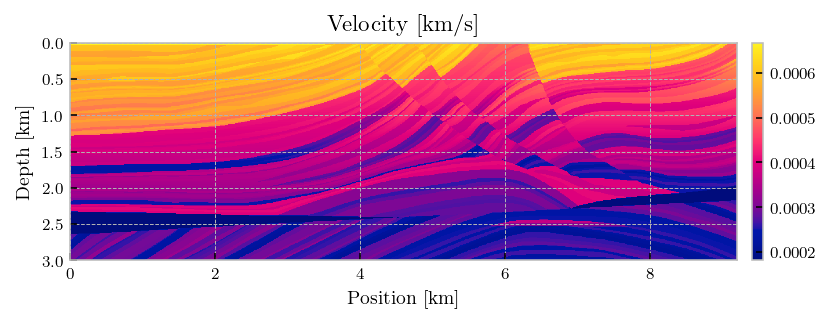

In [108]:
with np.load('marmousi.npz') as data:
    S_plot = 1/data['F']
fig = plt.figure()
fig.set_size_inches(6.5, 2)
ax = fig.gca()
im = ax.imshow(S_plot, **kwargs)
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Velocity [km/s]')
fig.subplots_adjust(right=0.95)
cax = fig.add_axes([0.91, 0.125, 0.012, 0.755])
fig.colorbar(im, cax=cax)
fig.savefig('marmousi-slowness.pdf', bbox_inches='tight')

# Extend model to 3D

In [12]:
tmp = np.empty((nz, nx, ny))
for k in range(ny):
    tmp[:, :, k] = F

F = tmp

# Define slowness

In [13]:
S = 1/F

In [14]:
print('min(S) = %g, max(S) = %g' % (S.min(), S.max()))

min(S) = 0.181818, max(S) = 0.666667


In [15]:
vx, vy, vz = 0.01, 0.006, -0.0053

Y, X, Z = np.meshgrid(
    np.linspace(xmin, xmax, nx),
    np.linspace(zmin, zmax, nz),
    np.linspace(ymin, ymax, ny),
    sparse=True
)

S += vx*X + vy*Y + vz*Z

In [16]:
print('min(S) = %g, max(S) = %g' % (S.min(), S.max()))

min(S) = 0.156607, max(S) = 0.721867


# Smooth model

In [66]:
sigma = 10
S = gaussian_filter(S, sigma=sigma)

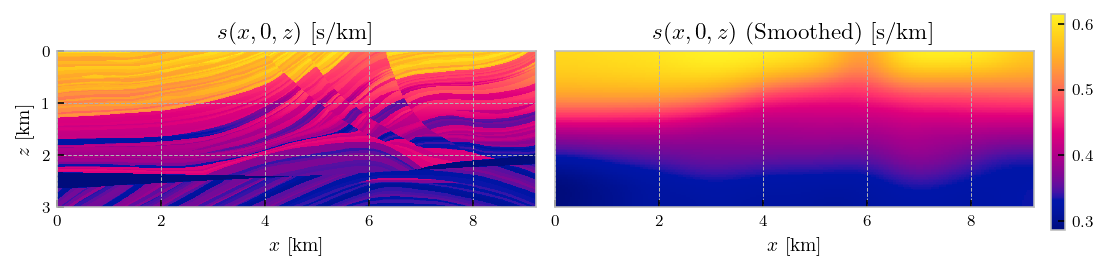

In [67]:
fig, axes = plt.subplots(1, 2)

fig.set_size_inches(8, 2)

ax = axes[0]
with np.load('marmousi.npz') as data:
    F = data['F']
    ax.imshow(1/F, **kwargs)
ax.set_title(r'$s(x, 0, z)$ [s/km]')

ax = axes[1]
im = ax.imshow(S[:, :, 0], **kwargs)
ax.set_title(r'$s(x, 0, z)$ (Smoothed) [s/km]')
ax.get_yaxis().set_visible(False)

for ax in axes:
    ax.set_ylabel(r'$z$ [km]')
    ax.set_xlabel(r'$x$ [km]')
    ax.set_aspect('equal')

fig.tight_layout()
    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.915, 0.16, 0.012, 0.75])
fig.colorbar(im, cax=cax)

fig.savefig('marmousi-slowness.pdf', bbox_inches='tight')

In [68]:
nb = pyolim.Neighborhood.OLIM3D
quad = pyolim.Quadrature.MP0

In [69]:
%%time
u = marmousi.solve_point_source_problem(S, nb, quad).U.copy()

CPU times: user 25.6 s, sys: 36.5 ms, total: 25.6 s
Wall time: 25.6 s


In [70]:
rescale_kwargs = dict(
    mode='constant', 
    multichannel=False, 
    anti_aliasing=False
)

In [71]:
L = np.arange(-4, 0).astype(np.float)

In [72]:
N = []
for l in L:
    N.append(rescale(S, 2**l, **rescale_kwargs).size)

In [73]:
str2nb = dict(
    olim6=pyolim.Neighborhood.OLIM6,
    olim26=pyolim.Neighborhood.OLIM26,
    olim3d=pyolim.Neighborhood.OLIM3D,
)
nbs, nb_strs = list(str2nb.values()), sorted(list(str2nb.keys()))

str2quad = dict(
    rhr=pyolim.Quadrature.RHR,
    mp0=pyolim.Quadrature.MP0
)
quads, quad_strs = list(str2quad.values()), list(str2quad.keys())

E = {
    (nb_str, quad_str): np.empty(len(L))
    for nb_str, quad_str in it.product(nb_strs, quad_strs)
}

In [74]:
for nb_str, quad_str, (i, l) in it.product(
    nb_strs, 
    quad_strs,
    enumerate(L)
):
    print('%s_%s, l = %g' % (nb_str, quad_str, l))
    nb, quad = str2nb[nb_str], str2quad[quad_str]
    Sl = rescale(S, 2**l, **rescale_kwargs)
    ul = rescale(u, 2**l, **rescale_kwargs)
    olim = marmousi.solve_point_source_problem(Sl, nb, quad)
    E[nb_str, quad_str][i] = rel_err(ul, olim.U)

olim26_rhr, l = -4
olim26_rhr, l = -3
olim26_rhr, l = -2
olim26_rhr, l = -1
olim26_mp0, l = -4
olim26_mp0, l = -3
olim26_mp0, l = -2
olim26_mp0, l = -1
olim3d_rhr, l = -4
olim3d_rhr, l = -3
olim3d_rhr, l = -2
olim3d_rhr, l = -1
olim3d_mp0, l = -4
olim3d_mp0, l = -3
olim3d_mp0, l = -2
olim3d_mp0, l = -1
olim6_rhr, l = -4
olim6_rhr, l = -3
olim6_rhr, l = -2
olim6_rhr, l = -1
olim6_mp0, l = -4
olim6_mp0, l = -3
olim6_mp0, l = -2
olim6_mp0, l = -1


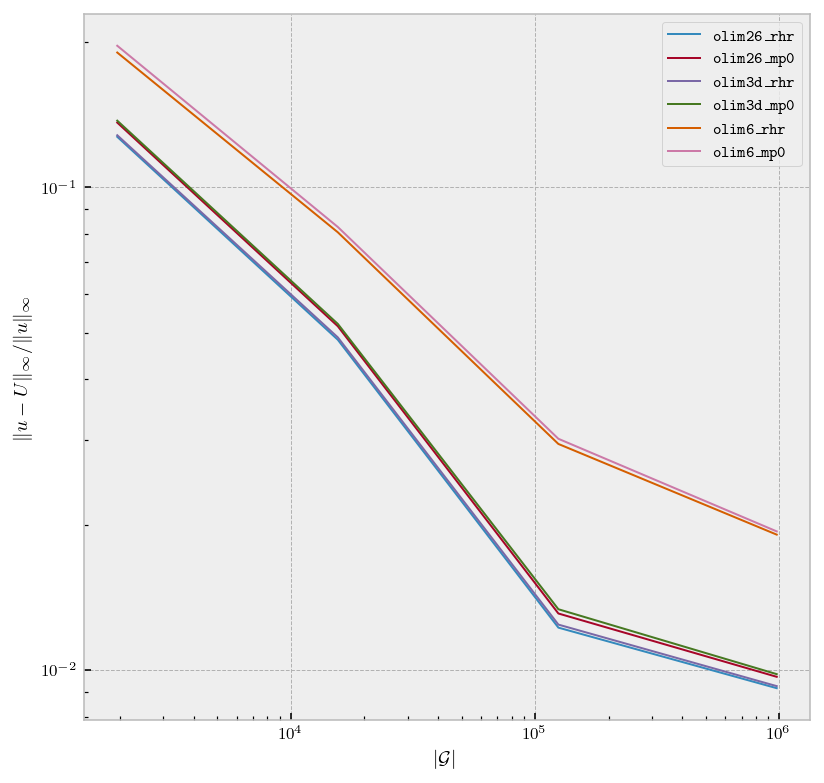

In [75]:
fig = plt.figure()
fig.set_size_inches(6.5, 6.5)

ax = fig.gca()

ax.minorticks_off()
ax.set_ylabel(r'$\|u - U\|_\infty/\|u\|_\infty$')
ax.set_xlabel('$|\mathcal{G}|$')

for nb_str, quad_str in it.product(nb_strs, quad_strs):
    ax.loglog(
        N, 
        E[nb_str, quad_str],
        linewidth=1,
        label=r'\texttt{%s\_%s}' % (nb_str, quad_str)
    )

ax.legend()

# Solve groundtruth model

In [28]:
h = zmax/(min(S.shape) - 1)

In [29]:
nb = pyolim.Neighborhood.OLIM3D
quad = pyolim.Quadrature.MP0
olim = pyolim.Olim(nb, quad, S, h)
olim.add_src((0, 0, 0))
olim.solve()

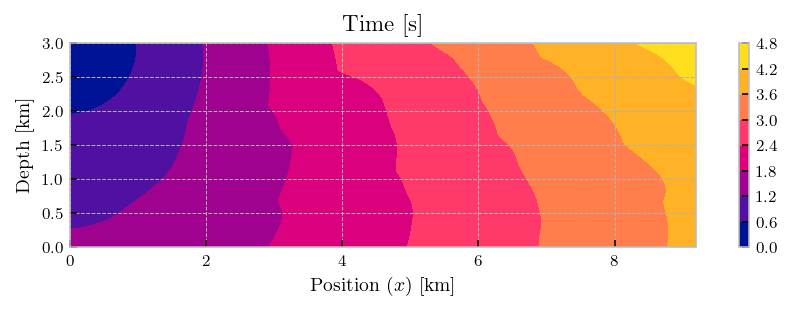

In [30]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.contourf(olim.U[:, :, 0], **kwargs)
ax.set_ylabel('Depth [km]')
ax.set_xlabel(r'Position ($x$) [km]')
ax.set_aspect('equal')
ax.set_title('Time [s]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Plot implicit surface for different $t$ values

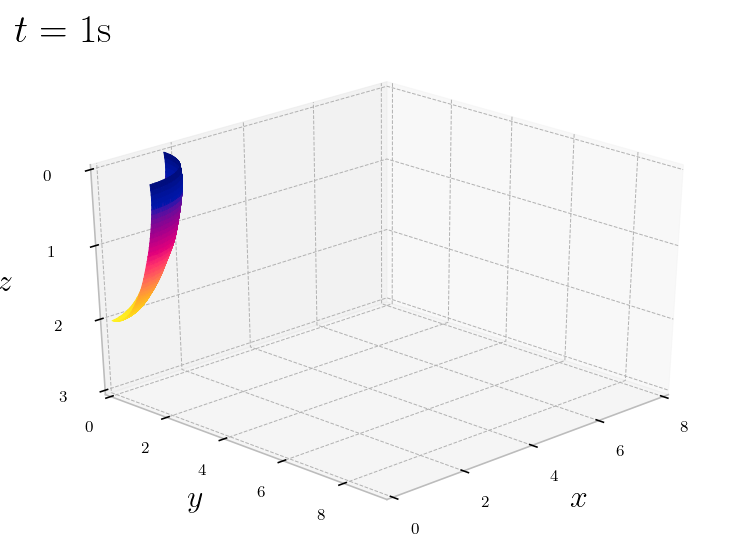

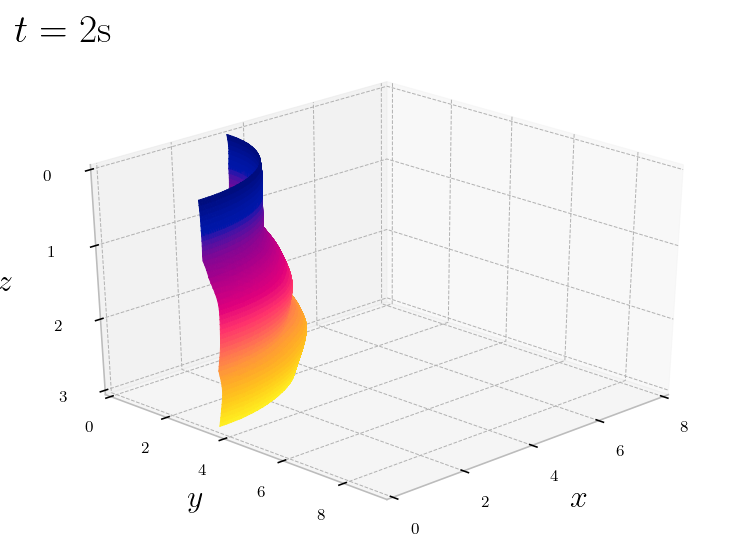

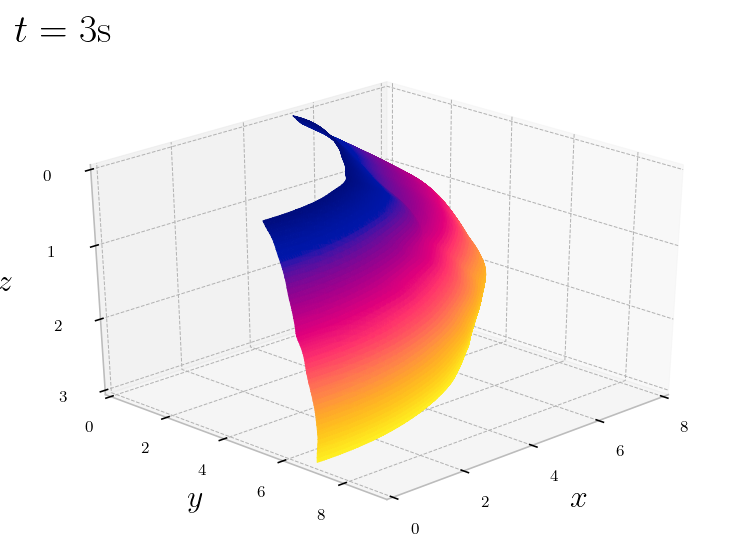

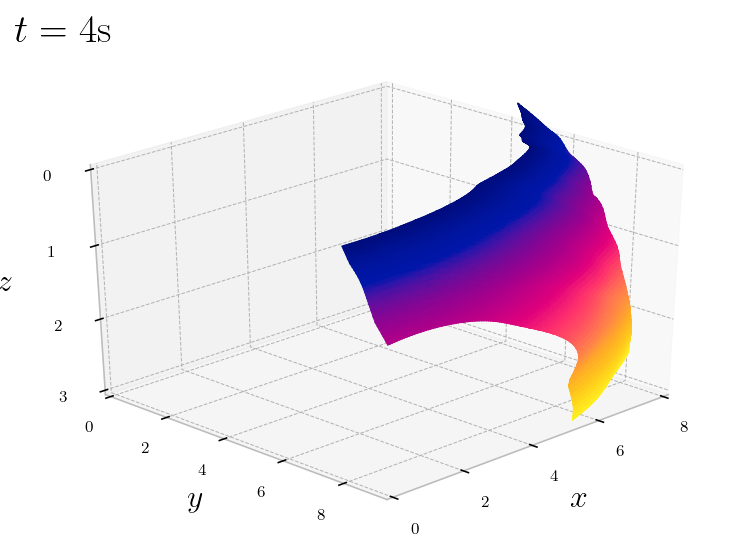

In [31]:
linewidth = 6.5

def plot_time(ax, t):
    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        np.transpose(olim.U, (2, 1, 0)), 
        t,
        step_size=2,
        spacing=(h, h, h)
    )
    centroids = np.mean(verts[faces], axis=1)
    colors = centroids[:, 2]
    colors -= colors.min()
    colors /= colors.ptp()
    colors = cmap(colors)
    ax.add_collection3d(
        Poly3DCollection(
            # [verts[faces].reshape(np.product(faces.shape), 3)],
            verts[faces],
            edgecolors=colors,
            facecolors=colors,
        )
    )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.view_init(30, 45)
    ax.autoscale_view(tight=True)
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_yticks([0, 2, 4, 6, 8])
    ax.set_zticks([0, 1, 2, 3])
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$y$', fontsize=16)
    ax.set_zlabel(r'$z$', fontsize=16)
    ax.set_title(r'$t = %d\mathrm{s}$' % t, loc='left', fontsize=20)

times = [1, 2, 3, 4]

for k, t in enumerate(times):
    fig = plt.figure()
    fig.set_size_inches(linewidth, (2/3)*linewidth)
    ax = fig.gca(projection='3d')
    ax.set_facecolor('white')
    plot_time(ax, t)
    fig.show()
    fig.savefig('marmousi-3d-t%d.pdf' % t, bbox_inches='tight')